# Quick primer on elections 

## Categories of vote

**Abstention**: The ballot expresses no preference, i.e., it is blank.


**Illegal**: The ballot expresses a preference which cannot be satisfied within the bounds of the election.
        
        In this election, this could involve:    
        - The voter writing-in a name which they also selected.
      
        Back when we conducted the election via Canvas, we also had to worry about:
        - The voter selecting more than the allowed number of candidates 
        - Selecting the maximum number and then writing in an additional candidate.

**Cast** = abstentions + legal + illegal
    
    - Cast plays no role except for auditing 

**Valid** = legal + illegal
    
    - These determine the denominator when a position requires a majority (i.e., > 50%)
    
    - Note that abstentions do not count in the denominator



__ TOOLS FOR MANAGING THE ELECTION. NOT FOR REPORTING. __

2019!

In [1]:
%cd ~/Dropbox/csun-election-management
YEAR =2019

#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set(style="whitegrid")

#Base Classes stuff
from FileSystemTools import *
from UtilityDecorators import *
from UtilityFunctions import *

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import counter.environment as env
from counter.QualitricsHelpers import get_results_column_names, get_write_in_column_names
from counter.QualitricsProcessors import process_results, save_results, process_field, process_voter, process_office_columns
from counter.FileSystemTools import makeDataFileList
# String processing of result cells
from counter.StringProcessors import find_dept, remove_depts

/Users/adam/Dropbox/csun-election-management


# Load and process data

## Get results file

In [6]:
general_results_file = "{}/general-{}.csv".format(env.RESULTS_FOLDER_PATH, YEAR)
sc_results_file = "{}/standing-committees-{}.csv".format(env.RESULTS_FOLDER_PATH, YEAR)
general_definition_file = "{}/general-definition-{}.xlsx".format(env.DEFINITIONS_FOLDER_PATH, YEAR)
sc_definition_file = "{}/standing-committees-definition-{}.xlsx".format(env.DEFINITIONS_FOLDER_PATH, YEAR)

In [3]:
def load_and_prepare(results_file):
    data = pd.read_csv(results_file)
    # Remove non-response rows
    dropped = data[data.index <= 1]
    data = data[data.index > 1]
    # remove unneeded columns
    drop_columns = ['DistributionChannel', 'UserLanguage', 'Status' ]
    data.drop(drop_columns, axis=1, inplace=True)
    data.dropna(how='all', axis=0, inplace=True)
    # format timestamps
    date_fields = ['StartDate', 'EndDate', 'RecordedDate']
    def make_ts(row):
        return pd.to_datetime(row[date_fields])
    data[date_fields] = data.apply(lambda x: make_ts(x), axis=1)
    return data


In [4]:
general_data = load_and_prepare(general_results_file)
sc_data = load_and_prepare(sc_results_file)

In [ ]:
# results_files = [f for f in makeDataFileList(env.INPUT_FOLDER_PATH) if f[-3:] == 'csv']
# data = pd.read_csv(results_files[0])

## Remove non-response rows

In [ ]:
# dropped = data[data.index <= 1]
# data = data[data.index > 1]

## Remove unneded columns

In [ ]:
# drop_columns = ['DistributionChannel', 'UserLanguage', 'Status' ]
# data.drop(drop_columns, axis=1, inplace=True)
# data.dropna(how='all', axis=0, inplace=True)

## Set timestamps

In [ ]:
# Voting dates
# date_fields = ['StartDate', 'EndDate', 'RecordedDate']
# def make_ts(row):
#     return pd.to_datetime(row[date_fields])
# data[date_fields] = data.apply(lambda x: make_ts(x), axis=1)

## Process the data

In [ ]:
from counter.Exceptions import OfficeProcessingError
from counter.DataObjects import OfficeElection
from counter.Definitions import OfficeDefinitions

# Read in the properties of the various offices
Definitions = OfficeDefinitions()

def process_results(frame):
    """This is the master processing function
    Returns a list of results objects for each office where no errors
    were encountered.
    """
    results = []
    
    results_columns = get_results_column_names(frame)
    for c in results_columns:
        # create a data store object
        office_name = Definitions.get_office_name_for_field(c)
        requires_maj = Definitions.office_requires_majority(c)
        write_in_columns = get_write_in_column_names(frame, c)
        r = OfficeElection(officeName=office_name, 
                           fieldName=c, 
                           writeInFieldNames=write_in_columns,
                          requires_majority=requires_maj
                          )
        # it will pull out the relevant columns
        r.add_data(frame)
        try:
            office_counts = process_office_columns(r)
            results.append(r)
        except OfficeProcessingError as err:
            # These blocked the results object from being added to the 
            # results list
            print("Error proccessing office: {}".format(office_name))
            for e in err.errors:
                print(e)
    return results


def save_results(output_file, results):
    """Writes results to output file"""
    with pd.ExcelWriter(output_file) as writer:
        for result in results:
#             print("Writing results of {} to file".format(result.officeName))
            result.vote_counts.to_excel(writer, sheet_name=result.officeName)


In [28]:
general_results = process_results(general_data, general_definition_file, 'general')
sc_results = process_results(sc_data, sc_definition_file, 'committees')

# save_results(env.OUTPUT_FILE, results)

/Users/adam/Desktop/Election/input/definitions/general-definition-2019.xlsx
/Users/adam/Desktop/Election/input/definitions/standing-committees-definition-2019.xlsx


# General election results

## Vote counts and percentage of total valid votes

NB, Officers of the Faculty and the Statewide Senator must be elected by a majority of votes. Thus for these offices we need a run off if 'pct_of_valid' is not greater than %50 for one candidate. 

I've nonetheless included the percentage of valid votes for all other offices in case it is of interest.

In [29]:
from IPython.display import display, Math, Latex, HTML

def show_results_tables(results):
    for r in results:
        out = """\\begin{figure}
        \\caption{%s}
        %s
        \\end{figure}""" % (r.officeName, r.combined_results_frame.T.to_latex())
        display(Latex(out))

In [30]:
show_results_tables(general_results)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Visualized

Here's the results data in chart form (sorry, it was too much of a pain to integrate these with the tables)

Again, the plots in the column on the right are unnecessary for senators-at-large and standing committees.

In [35]:
def plot_results(results, figsize=(17,25)):
#     n = round(len(results)/2)
    fig, axes = plt.subplots(nrows=len(results), ncols=2, figsize=figsize)
    row = 0; col=0
    for r in results:
        r.vote_counts.plot(kind='barh', title=r.officeName, ax=axes[row, 0])
        axes[row, 0].set_xlabel("Vote count")
        r.percentages_of_valid.plot(kind='barh', title=r.officeName + "-- Percentage of total valid votes", ax=axes[row, 1])
        axes[row, 1].set_xlabel("%")
        row +=1
    fig.tight_layout()

In [33]:
general_results

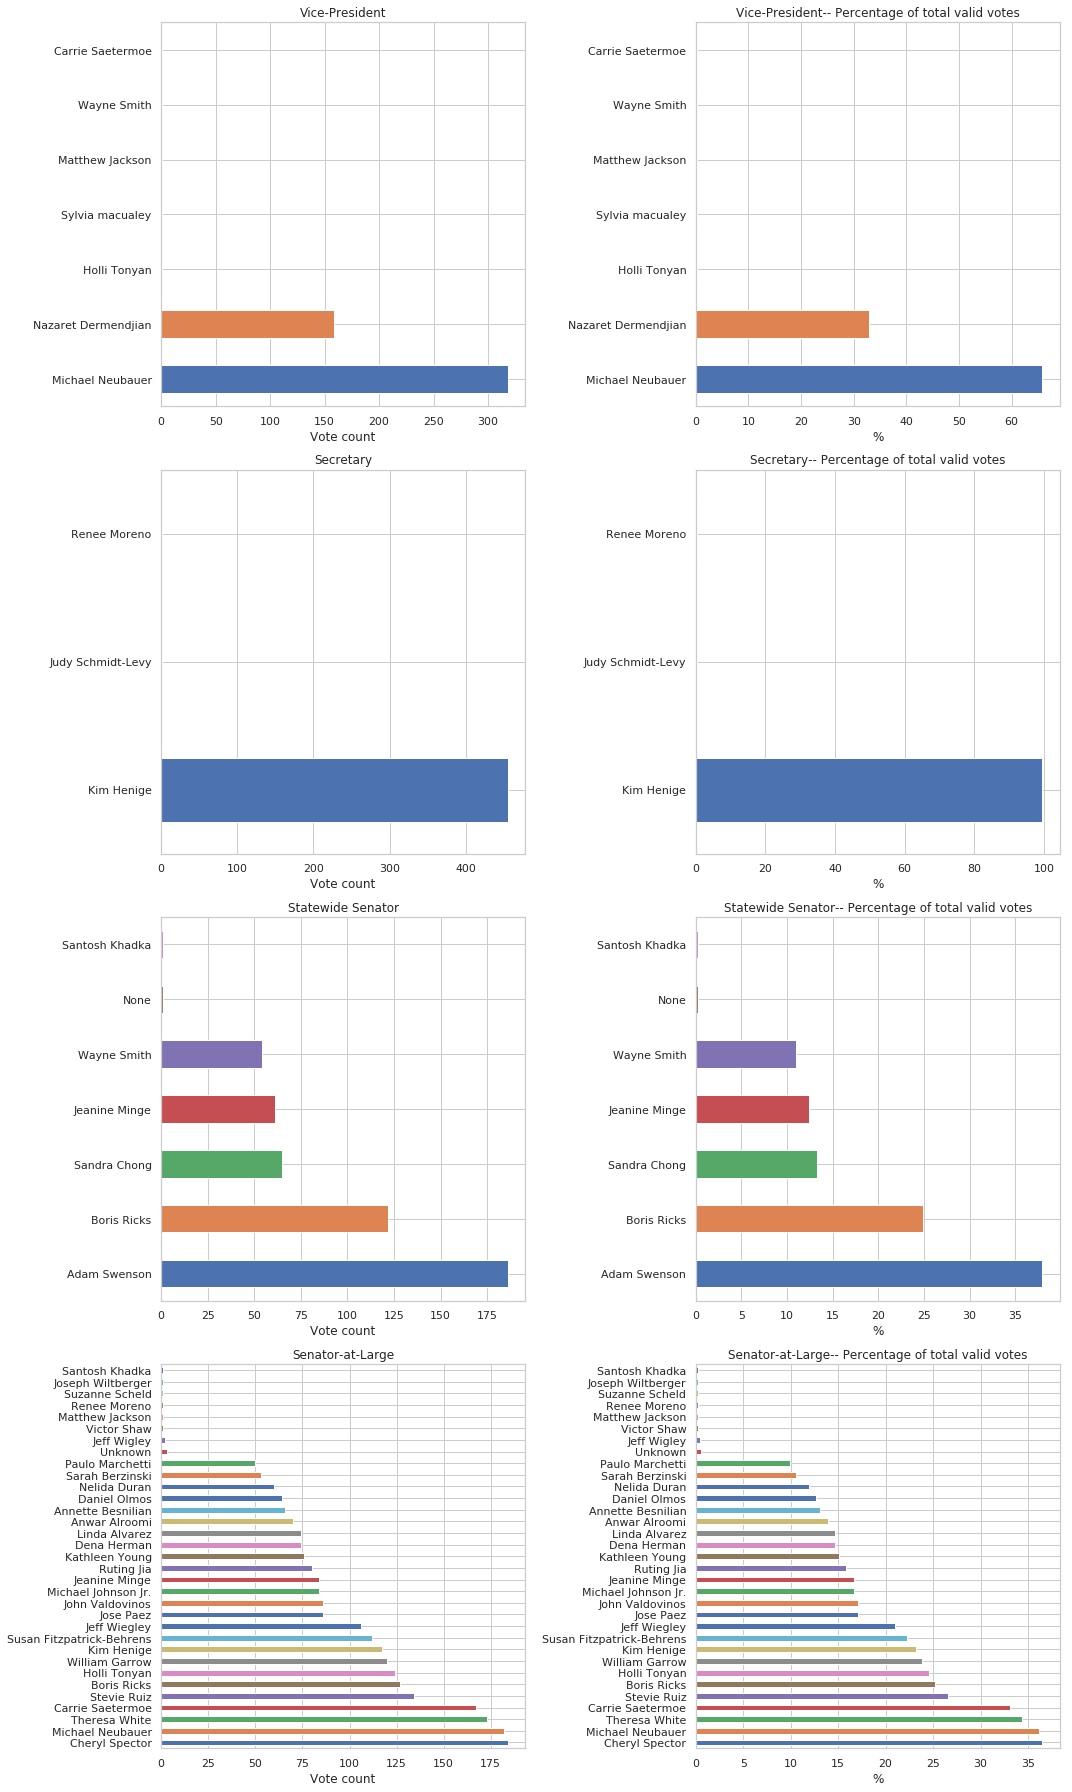

In [38]:
plot_results(general_results, (15, 25))

# Standing committees

## Vote counts and percentage of total valid votes

I've included the percentage of valid votes for all other offices in case it is of interest. For standing committees, there's no requirement that anyone receive any particular percentage.

In [39]:
show_results_tables(sc_results)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Visualized

Here's the results data in chart form.

Again, the plots in the column on the right are unnecessary standing committees.

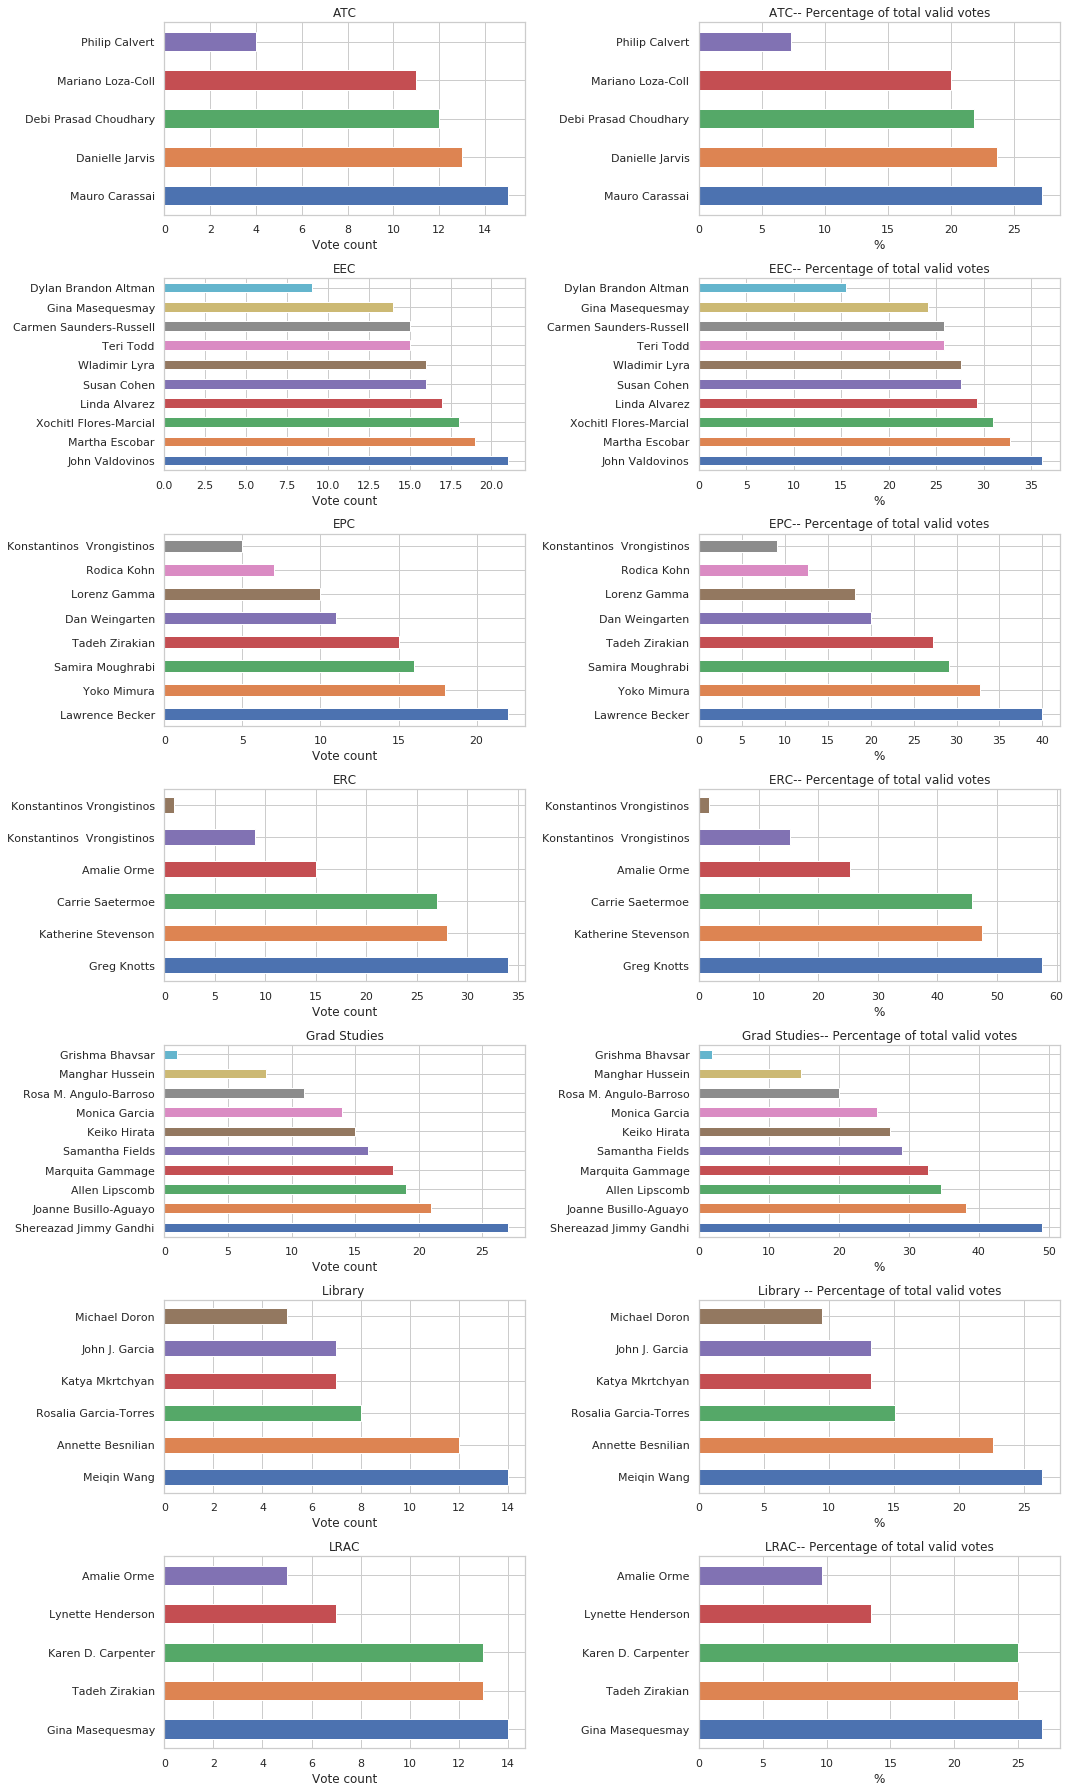

In [40]:
plot_results(sc_results, (15, 25))

For the ERC election, note that Dino's name had 2 spaces in between his first and last name on the ballot. The folks who chose to write his name in rather than selecting it added 1 space, thus my program didn't combine them.


# Abstentions

For completeness, it's worth looking briefly at abstentions. Those on the Senate know my militant view on abstentions. Holes are privations of dirt. Abstentions are privations of votes.^. 

This fits with the Robert's Rules treatment of abstentions, which governs our elections: only ballots which indicate a preference count toward vote totals. Writing in 'Anyone but these yahoos' expresses a preference. A blank ballot expresses the absence of a preference. Therefore, abstentions do not count in the denominator for offices which require the winner to obtain a majority.

There's not much to be learned from the amount of abstentions ---we cannot infer that voters hated all the candidates since it could've been that they loved them all equally.^^ But, for completeness, here they are: 


^ Technically, they exist but do not subsist

^^ For arguments that it isn't always rational to flip a coin in these cases, see (my former teacher) Ruth Chang's work on incommensurable values

In [43]:
def plot_abstentions(results):
    d = []
    for r in results:
        d.append({r.officeName : r.number_abstentions})
    abst = pd.DataFrame(d)
    fig, axes = plt.subplots(figsize=(8,5))
    abst.T.plot(kind='barh', title='Abstentions', ax=axes)
    axes.get_legend().remove()
    # axes.legend(loc=9, ncol=7, mode='expand', borderaxespad=0.)
    axes.set_xlabel("Count")
    fig.tight_layout()

In [41]:
def show_abstentions_tables(results):
    d = []
    for r in results:
        d.append({r.officeName : r.number_abstentions})
    abst = pd.DataFrame(d)
    display(Latex(abst.to_latex()))

## General election abstentions

In [42]:
show_abstentions_tables(general_results)

<IPython.core.display.Latex object>

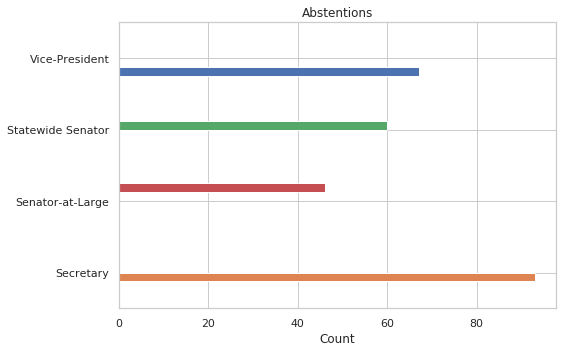

In [20]:
plot_abstentions(general_results)

## Standing committee abstentions

In [44]:
show_abstentions_tables(sc_results)

<IPython.core.display.Latex object>

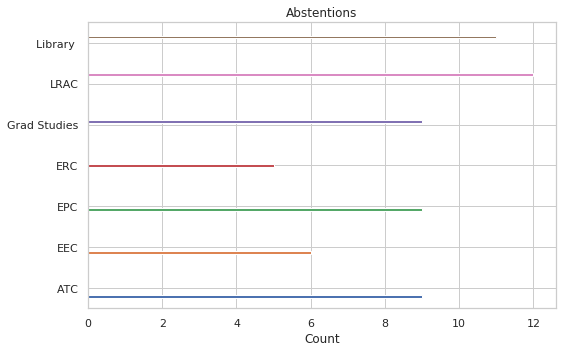

In [45]:
plot_abstentions(sc_results)

# General properties of the election

## Total votes cast

In [ ]:
cast = []
for r in results:
    cast.append({r.officeName : r.cast_votes})
cast = pd.DataFrame(cast)
display(Latex(cast.to_latex()))

In [ ]:
fig, axes = plt.subplots(figsize=(8,5))
cast.T.plot(kind='barh', title='Total votes cast', ax=axes)
axes.get_legend().remove()
axes.set_xlabel("Count")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
eligible = pd.read_excel(env.ELIGIBILITY_FILE_PATH)
eligible.set_index('year', inplace=True)

In [ ]:
eligible

## Daily marginal votes cast

In [ ]:
d= data.copy(deep=True)
d.set_index('RecordedDate', inplace=True)

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
d.resample('D')['ResponseId'].count().plot(kind='bar', ax=axes)
axes.set_ylabel('# votes'); axes.set_title("Daily marginal votes"); axes.set_xlabel('Date')
xtl=[item.get_text()[:10] for item in axes.get_xticklabels()]
_=axes.set_xticklabels(xtl)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
i = 0
for v in d.resample('D')['ResponseId'].count():
    print(senateData.columns[i], v)
    senateData.loc[2019][senateData.columns[i]] = v
    i += 1

In [ ]:
d.resample('D')['ResponseId'].count().cumsum()


In [ ]:
def load_past_returns(election_type):
    # Load the correct df
    sheet = "Data-{}".format(election_type.lower())
#     sheet = 'Data-senate' if election_type == 'senate' else 'Data-general'
    pastData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name=sheet)
    pastData.set_index('Year', inplace=True)
    return pastData

def update_returns(frame_w_timestamp_index, election_type, year, save=False):
    """Adds the daily cumulative sum of vote counts for the presesnt year to the
    data for past years"""
    past = load_past_returns(election_type)
    # Calcluate marginal votes for present year and add
    i = 0
    for v in frame_w_timestamp_index.resample('D')['ResponseId'].count().cumsum():
        past.loc[year, past.columns[i]] = v
        i += 1
    if save:
        sheet = "Data-{}".format(election_type.lower())
        past.to_excel(env.PAST_RETURNS_FILE_PATH, sheet_name=sheet)
    return past


In [ ]:
d = data.set_index('RecordedDate')
returns = update_returns(d, 'senate', 2019, True)
returns.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
returns.dropna(axis=1, how='all', inplace=True)

In [ ]:
t = "General election"
fig, axes = plt.subplots(figsize=(8,4))
returns.T.plot(ax=axes)
axes.set_title("%s -- total votes" % t)
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

In [ ]:
def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

returnsProport = returns.apply(lambda x : calc_proport_of_eligible(eligible['standing_committees'], x.index, x))

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
returnsProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

In [ ]:
returnsProport

In [ ]:
senateData

In [ ]:
generalData.columns

In [ ]:
generalData

In [ ]:
generalData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name='Data-general')
generalData.set_index('Year', inplace=True)
generalEligible = generalData['Eligible']
generalData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
generalData.dropna(axis=1, how='all', inplace=True)

senateData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name='Data-senate')
senateData.set_index('Year', inplace=True)
senateEligible = senateData['Eligible']
senateData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
senateData.dropna(axis=1, how='all', inplace=True)


def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

generalProport = generalData.apply(lambda x : calc_proport_of_eligible(generalEligible, x.index, x))
senateProport =  senateData.apply(lambda x : calc_proport_of_eligible(senateEligible, x.index, x))

# Problem cases

2 candidates with same name
    
    Same dept
    
    Different dept
    
Write in candidate with no dept

Write in candidate with dept in parentheses

Write in candidate with dept, no parentheses

Vote for 1 candidate, write in same candidate (up to num allowed -1)

Write in multiple candidates in one field

Write same candidate in multiple times

# General election

## Total votes cast

In [ ]:
generalData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalData.T.plot(ax=axes)
axes.set_title("General election -- total votes")
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalProport.T.plot(ax=axes)
axes.set_title("General election returns -- proportion of eligible voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Daily marginal votes cast

In [ ]:
generalMarginal = generalData.T.sub(generalData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
generalMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=generalMarginal.dropna(axis=1), ax=axes)
axes.set_title("General election - marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (generalMarginal.index.min(), generalMarginal.index.max()))
fig.tight_layout()

# Senate-elected positions election 

## Total votes cast

In [ ]:
senateData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateData.T.plot(ax=axes)
axes.set_title("Senate-elected positions election --- total votes")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Votes cast per day

In [ ]:
senateMarginal = senateData.T.sub(senateData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
senateMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=senateMarginal.dropna(axis=1), ax=axes)
axes.set_title("Senate-elected positions -- marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (senateMarginal.index.min(), senateMarginal.index.max()))
fig.tight_layout()

# Election design and machinery

In [ ]:
ELECTION_YEAR = 2018
resultsFolder = "%s/Box Sync/Faculty Senate Collaborative Documents/Elections/Results/" % BASE
currentElection = "%s/%s Elections official results" % (resultsFolder, ELECTION_YEAR)
senateFolder = "%s/senate official results" % currentElection
generalFolder = "%s/general official results" % currentElection

In [ ]:
resultFileString = "Results.xlsx"
senateFiles = [f for f in makeDataFileList(senateFolder) if f[-12:] == resultFileString]
generalFiles = [f for f in makeDataFileList(generalFolder) if f[-12:] == resultFileString]
senateFrames = [pd.read_excel(f) for f in senateFiles]
generalFrames = [pd.read_excel(f) for f in generalFiles]

In [ ]:
def number_of_abstentions(frame):
    """Returns the number of blank ballots minus the
    number of write in votes"""
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
    abstentions = frame[frame[committeeName] == 'abstentions']['votes']
    abstentions = int(abstentions)
    # now we need to subtract the writeins
    # since any write-in will be  counted as an
    # abstention
    #
    # !!!!!!!!!!!!! todo double-check in code
    try:
        wi = frame[frame[committeeName] == 'writeins-unverified']['votes']
        wi = int(wi)        
        abstentions = abstentions + wi
    except:
        pass
    return (committeeName, abstentions)

def number_of_illegal_overselections(frame):
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
#     print(committeeName)
    v = frame[frame[committeeName] == 'illegal-overselection']['votes']
    v = int(v)
    return (committeeName, v)

def number_manually_disqualified(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    # get rid of any of the programmatically added columns
    v = frame.dropna()
    # add up the disqualified votes
    v = int(v.dq.sum())
    return (committeeName, v)

def number_illegal(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    #programmaticOverselections: too many boxes ticked
    po = number_of_illegal_overselections(frame)
    #write ins which invalidated the vote
    wi = number_manually_disqualified(frame)
    num =  po[1] + wi[1]
    return (committeeName, num)  

In [ ]:
def get_frame_for_plotting(func, columnName):
    v =  [func(frame) for frame in senateFrames]
    v =  v + [func(frame) for frame in generalFrames]
    return DataFrame(v, columns=['election', columnName]).set_index('election')

def plot_frame(frame, title, ylabel):
    fig, axes = plt.subplots(figsize=(8,3))
    frame.plot(kind='bar', table=True, ax=axes)
    x_axis = axes.get_xaxis(); axes.set_ylabel(ylabel)
    x_axis.set_visible(False); axes.set_title(title)
    fig.tight_layout()

In [ ]:
overselections = get_frame_for_plotting(number_of_illegal_overselections, 'over-selections')
plot_frame(overselections,  'Number ballots spoiled by too many candidates being selected', 'count')


## Write-in boxes


In [ ]:
dq = get_frame_for_plotting(number_manually_disqualified, 'disqualified')
plot_frame(dq,"Number of ballots disqualified due to write-ins", "# of ballots disqualified")

### Abstentions 


In [ ]:
abstentions = get_frame_for_plotting(number_of_abstentions, 'abstentions')
plot_frame(abstentions, "Number of blank ballots", "# of privations")

# Questions:
- How many votes were invalid because of the overselection (illegal-overselction + invalid) in each election?

- How many abstentions were there

In [ ]:
SENATE_VOTES = 50 #todo refer to value calculated above, just need election year
SENATE_ELLIGIBLE = 71 #todo refer to value calculated above, just need election year

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in generalFrames]
# illegalVotes = DataFrame(illegalVotes, columns=['Office', 'Illegal votes'])
#abstentions

In [ ]:
generalAbstentions =  [number_of_abstentions(frame) for frame in generalFrames]
generalAbstentions = DataFrame(generalAbstentions, columns=['Position', 'Abstentions'])


In [ ]:
abstentions

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in senateFrames]
illegalVotes = DataFrame(illegalVotes, columns=['election', 'Illegal votes'])
# these are included in illegal
overselections = [number_of_illegal_overselections(frame) for frame in senateFrames]
overselections = DataFrame(overselections, columns=['election', 'Overselections'])

data = pd.merge(left=abstentions, right=illegalVotes, on='election').set_index('election')

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
data.plot(kind='bar', ax=axes)
axes.set_title("Counts of abstentions and illegal votes for standing committee elections")
axes.set_ylabel("Count")
fig.tight_layout()

In [ ]:
pctEligible = data.copy(deep=True)
pctVoters = data.copy(deep=True)
pctVoters.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)
pctEligible.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)


pctEligible['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_ELLIGIBLE)
pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

pctVoters['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_VOTES)
pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

# pctEligible['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))
# pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))

# pctVoters['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_VOTES) * 100))
# pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE) * 100))

In [ ]:
fig, axes = plt.subplots(nrows=2)
pctEligible.plot(kind='bar', ax=axes[0])
axes[0].set_title("Abstentions and illegal votes as proportion of eligible voters")
axes[0].set_ylabel("count / # eligible ")
pctVoters.plot(kind='bar', ax=axes[1])
axes[1].set_ylabel("count / # case ")
axes[1].set_title("Abstentions and illegal votes as proportion of votes cast")
fig.tight_layout()